# Cybersecurity Intrusion Detection Dataset - Logistic Regression

### [Cybersecurity Intrusion Detection Dataset](https://www.kaggle.com/datasets/dnkumars/cybersecurity-intrusion-detection-dataset)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Citation

[1] Dinesh Naveen Kumar Samudrala, https://kaggle.com/dnkumars

## Import Modules

In [168]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Load Dataset

In [169]:
df = pd.read_csv('cybersecurity_intrusion_data-clean.csv')

## Logistic Regression

### Visualize Relationship Between the Output and Each Continuous Input Colored by Browser Type

Across these six panels, we see how each feature correlates with the probability of an attack being detected (y-axis), with separate regression lines for each browser type as login attempts and failed logins exhibit the strongest positive relationship more attempts or failures dramatically increase the likelihood of flagging an attack—while the red “Unknown” browser line is consistently steeper than the others. IP reputation score also shows a clear upward trend: lower scores correspond to few detections and higher scores to many; session duration has a moderate positive slope as well, suggesting that unusually long sessions can be a red flag, albeit less dramatically than failed logins. By contrast, network packet size and unusual time access display very weak relationships: their regression lines are almost flat, indicating little predictive power in isolation; although there are minor browser-specific offsets, Safari tends to have a slightly lower base detection rate, and Unknown slightly higher—the dominant drivers of detection are clearly the counts of login attempts and failures, followed by IP reputation.

There are very clear relationships between both the number of login attempts, failed logins, and IP repuation score with the target variable.

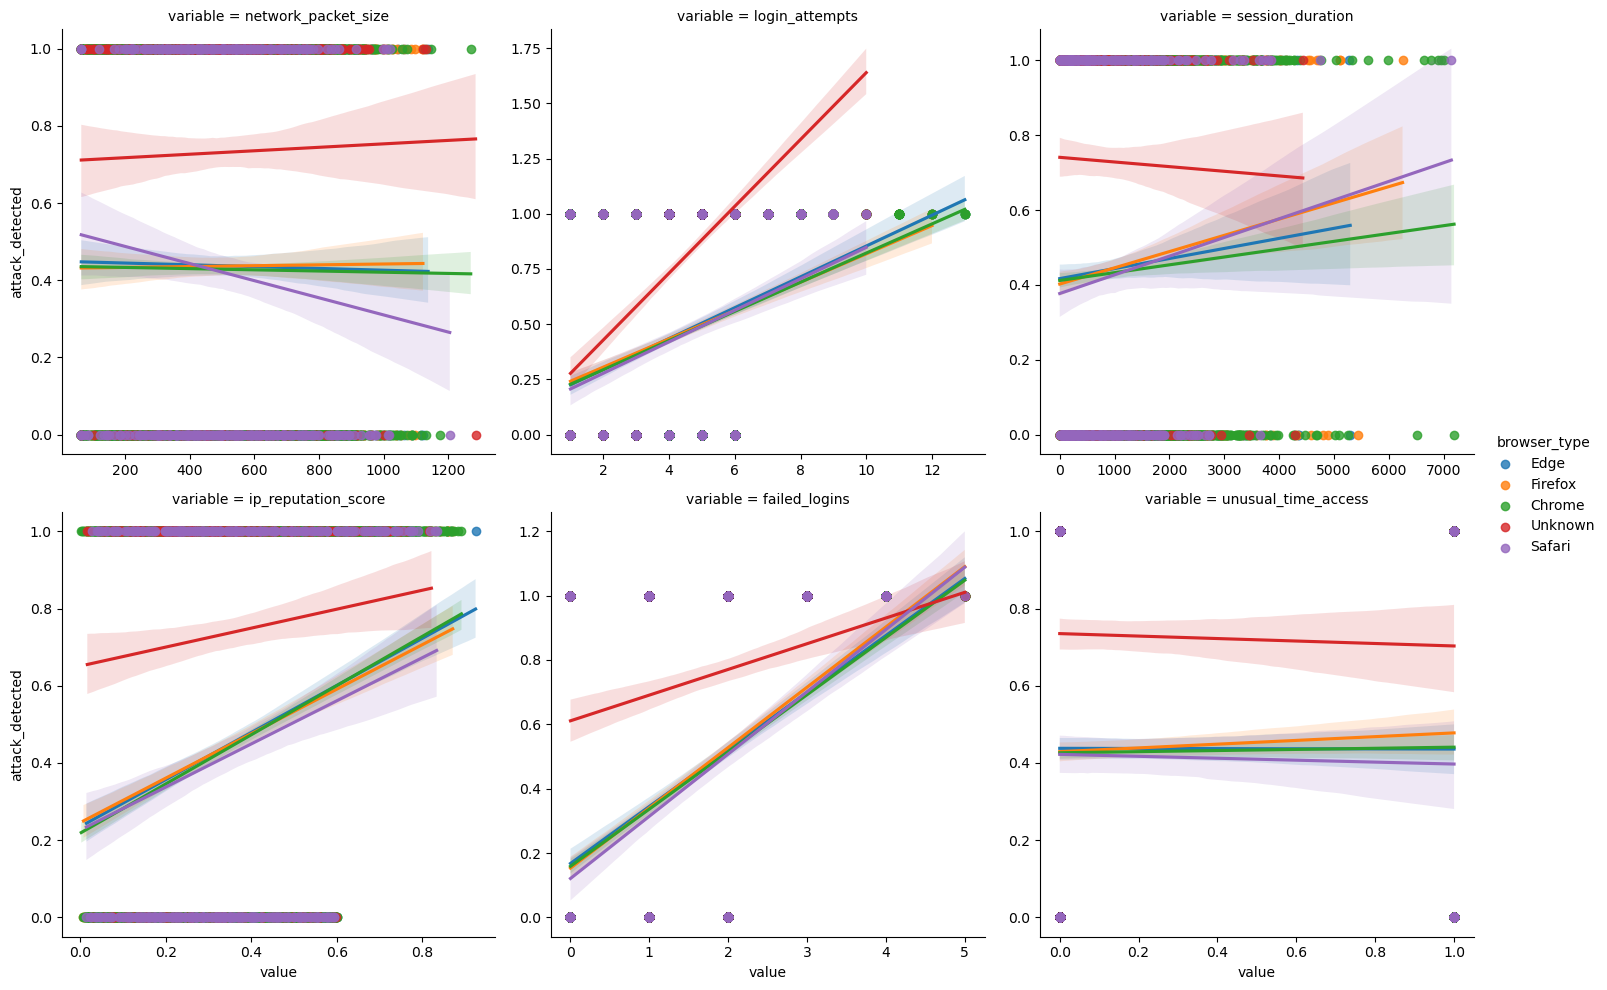

In [170]:
sns.lmplot(
    data=df. \
         reset_index(). \
         rename(columns={'index':'rowid'}). \
         melt(id_vars=['rowid',
                       'attack_detected',
                       'browser_type'],
         value_vars=['network_packet_size',
                     'login_attempts',
                     'session_duration',
                     'ip_reputation_score',
                     'failed_logins',
                     'unusual_time_access']),
    x='value',
    y='attack_detected',
    col='variable',
    col_wrap=3,
    hue='browser_type',
    facet_kws={'sharey': False, 
               'sharex': False})
plt.show()

## Initially Fit Logistic Regression Models - Training Data

### Functions

In [171]:
def fit_and_assess_logit(y,
                         model, 
                         formula, 
                         df,
                         threshold=0.5):
    """
    Fits an logit logistic regression model using statsmodels and returns model metrics.
    
    Parameters
    ----------
    y : str
        The name of the target variable.
    model : str
        A descriptive name for the model.
    formula : str
        A statsmodels formula string specifying the regression model.
    df : pandas.DataFrame
        The input data to fit the model.
    threshold : float
        The threshold for classifying predicted probabilities.

    Returns
    -------
    pandas.DataFrame
        A single-row DataFrame containing:
            - model_name: Name of the model
            - model_formula: Formula used for fitting
            - num_coefs: Number of estimated coefficients
            - threshold: Threshold used for classification
            - Accuracy: (TP + TN) / total observations
            - Sensitivity: TP / (TP + FN)
            - Specificity: TN / (TN + FP)
            - FPR: FP / (FP + TN)
            - ROC_AUC: Area under the ROC curve
    """
    # Fit the model
    a_model = smf.logit(formula=formula, data=df).fit()

    # Generate predictions and classify based on threshold
    df_copy = df.copy()
    df_copy['pred_probability'] = a_model.predict(df_copy)
    df_copy['pred_class'] = (df_copy['pred_probability'] >= threshold).astype(int)

    # Compute confusion matrix and derived metrics
    TN, FP, FN, TP = confusion_matrix(df_copy[y],
                                      df_copy. \
                                      pred_class. \
                                      to_numpy()). \
                                      ravel()

    # Compute performance metrics
    Accuracy = (TN + TP) / (TN + FP + FN + TP)
    Sensitivity = (TP) / (TP + FN)
    Specificity = (TN) / (TN + FP)    
    FPR = 1 - Specificity
    ROC_AUC = roc_auc_score(df_copy[y], 
                            df_copy. \
                            pred_probability. \
                            to_numpy())

    # Extract model metrics
    results_dict = {'model_name': model,
                    'model_formula': formula,
                    'num_coefs': len(a_model.params),
                    'threshold': threshold,
                    'Accuracy': Accuracy,
                    'Sensitivity': Sensitivity,
                    'Specificity': Specificity,
                    'FPR': FPR,
                    'ROC_AUC': ROC_AUC}

    # Return results as DataFrame
    return pd.DataFrame(results_dict, index=[0])

In [172]:
def my_coefplot(model, 
                figsize_use=(10, 8), 
                zero_nudge=125):
    """
    Create a coefficient plot of a fitted statsmodels regression model.

    This function visualizes the estimated coefficients of a regression model with their
    confidence intervals (approximated as ±2 standard errors).
    Statistically significant coefficients (p < 0.05) are shown in red.

    Parameters
    ----------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        A fitted statsmodels regression model, e.g., the result of smf.ols(...).fit().
    figsize_use : tuple, optional
        Size of the matplotlib figure, default is (10, 4).
    zero_nudge : float, optional
        Amount to nudge significant coefficients away from zero for visual clarity. Default is 125.

    Returns
    -------
    None
        Displays a matplotlib plot showing the model coefficients and their error bars.
    """
    # Create the figure and axis
    _, ax = plt.subplots(figsize=figsize_use)

    # Nudge coefficients very close to zero for visual clarity
    coefs = model.params.copy()
    coefs[np.isclose(coefs, 0, atol=zero_nudge)] = zero_nudge

    # Determine colors for coefficients based on significance
    colors = ['red' if p < 0.05 else 'black' for p in model.pvalues]

    # Plot each coefficient with its color
    for _, (y, x, xerr, color) in enumerate(zip(coefs.index, coefs, 2 * model.bse, colors)):
        ax.errorbar([x], 
                    [y], 
                    xerr=[xerr], 
                    fmt='o', 
                    color=color, 
                    ecolor=color, 
                    elinewidth=2, 
                    ms=10)

    # Add a vertical line at x=0
    ax.axvline(x=0, 
               linestyle='--', 
               linewidth=3.5, 
               color='grey')

    # Add labels and title
    ax.set_xlabel('Coefficient Value')

    # Show the plot
    plt.show()

### Formulas

In [173]:
df.dtypes

network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

In [174]:
formula_list = [
    # Model 00: Intercept-Only (Baseline)
    'Q("attack_detected") ~ 1',

    # Model 01: Categorical Predictors Only
    'Q("attack_detected") ~ '
    'C(Q("protocol_type"))'
    ' + C(Q("encryption_used"))'
    ' + C(Q("browser_type"))',

    # Model 02: Continuous Predictors, Linear Additive
    'Q("attack_detected") ~ '
    'Q("network_packet_size")'
    ' + Q("login_attempts")'
    ' + Q("session_duration")'
    ' + Q("ip_reputation_score")'
    ' + Q("failed_logins")'
    ' + Q("unusual_time_access")',

    # Model 03: Continuous Predictors + Categorical (Additive)
    'Q("attack_detected") ~ '
    'Q("network_packet_size")'
    ' + Q("login_attempts")'
    ' + Q("session_duration")'
    ' + Q("ip_reputation_score")'
    ' + Q("failed_logins")'
    ' + Q("unusual_time_access")'
    ' + C(Q("protocol_type"))'
    ' + C(Q("encryption_used"))'
    ' + C(Q("browser_type"))',

    # Model 04: Continuous Predictors with Pairwise Interactions and Quadratic Terms
    'Q("attack_detected") ~ '
    'Q("network_packet_size")'
    ' + Q("login_attempts")'
    ' + Q("session_duration")'
    ' + Q("ip_reputation_score")'
    ' + Q("failed_logins")'
    ' + Q("unusual_time_access")'
    ' + Q("network_packet_size"):Q("login_attempts")'
    ' + Q("network_packet_size"):Q("session_duration")'
    ' + Q("login_attempts"):Q("session_duration")'
    ' + I(Q("network_packet_size")**2)'
    ' + I(Q("login_attempts")**2)'
    ' + I(Q("session_duration")**2)',

    # Model 05: Categorical Interacting with All Continuous Predictors
    'Q("attack_detected") ~ '
    'C(Q("protocol_type")) * ('
    'Q("network_packet_size")'
    ' + Q("login_attempts")'
    ' + Q("session_duration")'
    ' + Q("ip_reputation_score")'
    ' + Q("failed_logins")'
    ' + Q("unusual_time_access")'
    ')'
    ' + C(Q("encryption_used")) + C(Q("browser_type"))',

    # Model 06: Higher-Order Polynomials on Session Duration
    'Q("attack_detected") ~ '
    'Q("network_packet_size")'
    ' + Q("login_attempts")'
    ' + Q("session_duration")'
    ' + I(Q("session_duration")**2)'
    ' + I(Q("session_duration")**3)'
    ' + Q("ip_reputation_score")'
    ' + Q("failed_logins")'
    ' + Q("unusual_time_access")'
    ' + C(Q("protocol_type"))'
    ' + C(Q("encryption_used"))'
    ' + C(Q("browser_type"))',

    # Model 07: All Predictors, Continuous Interactions, and Categorical (Full Candidate)
    'Q("attack_detected") ~ '
    '(Q("network_packet_size") + Q("login_attempts") + Q("session_duration") '
    '+ Q("ip_reputation_score") + Q("failed_logins") + Q("unusual_time_access"))**2'
    ' + C(Q("protocol_type"))'
    ' + C(Q("encryption_used"))'
    ' + C(Q("browser_type"))',

    # Model 08: Final Model (IP Reputation Score Slope Varies by Protocol Type)
    'Q("attack_detected") ~ '
    'Q("ip_reputation_score")'
    ' + Q("network_packet_size")'
    ' + C(Q("protocol_type"))'
    ' + Q("ip_reputation_score"):C(Q("protocol_type"))'
    ' + Q("login_attempts")'
    ' + Q("session_duration")'
    ' + Q("failed_logins")'
    ' + Q("unusual_time_access")'
    ' + C(Q("encryption_used"))'
    ' + C(Q("browser_type"))',

    # Model 09: Target on login_attempts, failed_logins, and ip_reputation_score (Additive)
    'Q("attack_detected") ~ '
    'Q("login_attempts")'
    ' + Q("failed_logins")'
    ' + Q("ip_reputation_score")',

    # Model 10: Target on login_attempts, failed_logins, and ip_reputation_score (Interactions)
    'Q("attack_detected") ~ '
    'Q("login_attempts")'
    ' + Q("failed_logins")'
    ' + Q("ip_reputation_score")'
    ' + Q("login_attempts"):Q("failed_logins")'
    ' + Q("login_attempts"):Q("ip_reputation_score")'
    ' + Q("failed_logins"):Q("ip_reputation_score")',

    # Model 11: Quadratic terms for login_attempts, failed_logins, ip_reputation_score
    'Q("attack_detected") ~ '
    'Q("login_attempts")'
    ' + Q("failed_logins")'
    ' + Q("ip_reputation_score")'
    ' + I(Q("login_attempts")**2)'
    ' + I(Q("failed_logins")**2)'
    ' + I(Q("ip_reputation_score")**2)',

    # Model 12: Cubic terms for login_attempts, failed_logins, ip_reputation_score
    'Q("attack_detected") ~ '
    'Q("login_attempts")'
    ' + Q("failed_logins")'
    ' + Q("ip_reputation_score")'
    ' + I(Q("login_attempts")**3)'
    ' + I(Q("failed_logins")**3)'
    ' + I(Q("ip_reputation_score")**3)',

    # Model 13: Quartic terms for login_attempts, failed_logins, ip_reputation_score
    'Q("attack_detected") ~ '
    'Q("login_attempts")'
    ' + Q("failed_logins")'
    ' + Q("ip_reputation_score")'
    ' + I(Q("login_attempts")**4)'
    ' + I(Q("failed_logins")**4)'
    ' + I(Q("ip_reputation_score")**4)'
]

### Model 00: Intercept-Only (Baseline)

In [175]:
model_00 = smf.logit(formula=formula_list[0], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.687540
         Iterations 4


In [176]:
model_00.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9536
Method:                             MLE   Df Model:                            0
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:               5.058e-11
Time:                          21:40:57   Log-Likelihood:                -6557.1
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2124      0.021    -10.313      0.000      -0.253      -0.172
==============================================================================
"""

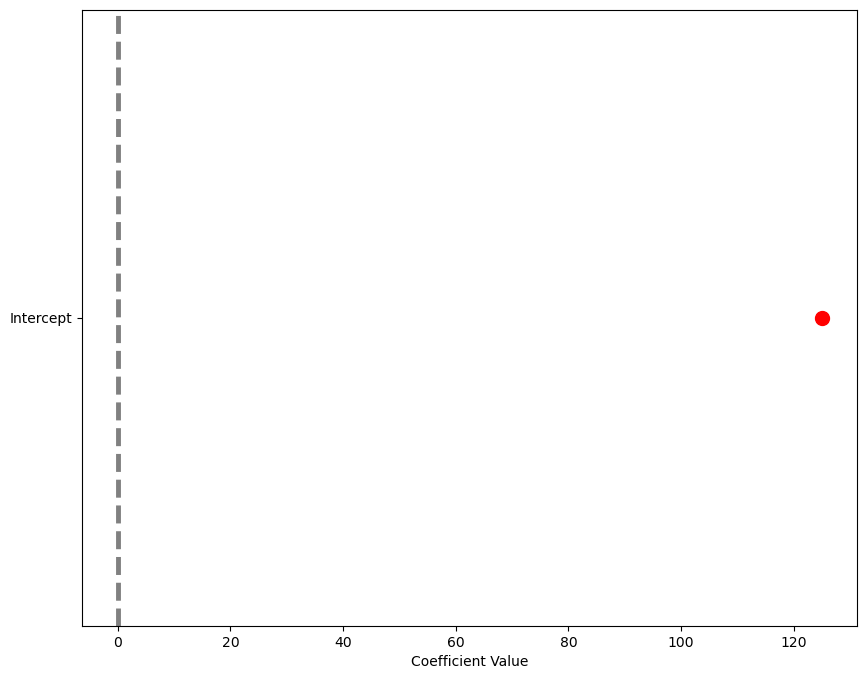

In [177]:
my_coefplot(model_00)

### Model 01: Categorical Predictors Only

In [178]:
model_01 = smf.logit(formula=formula_list[1], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.677881
         Iterations 5


In [179]:
model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9528
Method:                             MLE   Df Model:                            8
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                 0.01405
Time:                          21:40:57   Log-Likelihood:                -6465.0
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                 1.329e-35
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -0.4764      0.095     -5.006      0.000      -0.663      -0.290
C(Q("protocol_type"))[T.TCP]        0.1474      0.094      1.560      0.119      -0.038       0.333
C(Q("protocol_type"))[T.UDP]        0.1615      0.100      1.613      0.107      -0.035       0.358
C(Q("encryption_used"))[T.DES]      0.0783      0.048      1.628      0.103      -0.016       0.173
C(Q("encryption_used"))[T.NONE]     0.1113      0.054      2.044      0.041       0.005       0.218
C(Q("browser_type"))[T.Edge]        0.0363      0.060      0.608      0.543      -0.081       0.153
C(Q("browser_type"))[T.Firefox]     0.0297      0.054      0.552      0.581      -0.076       0.135
C(Q("browser_type"))[T.Safari]     -0.0423      0.096     -0.439      0.661      -0.231       0.147
C(Q("browser_type"))[T.Unknown]     1.2889      0.105     12.322      0.000       1.084       1.494
===================================================================================================
"""

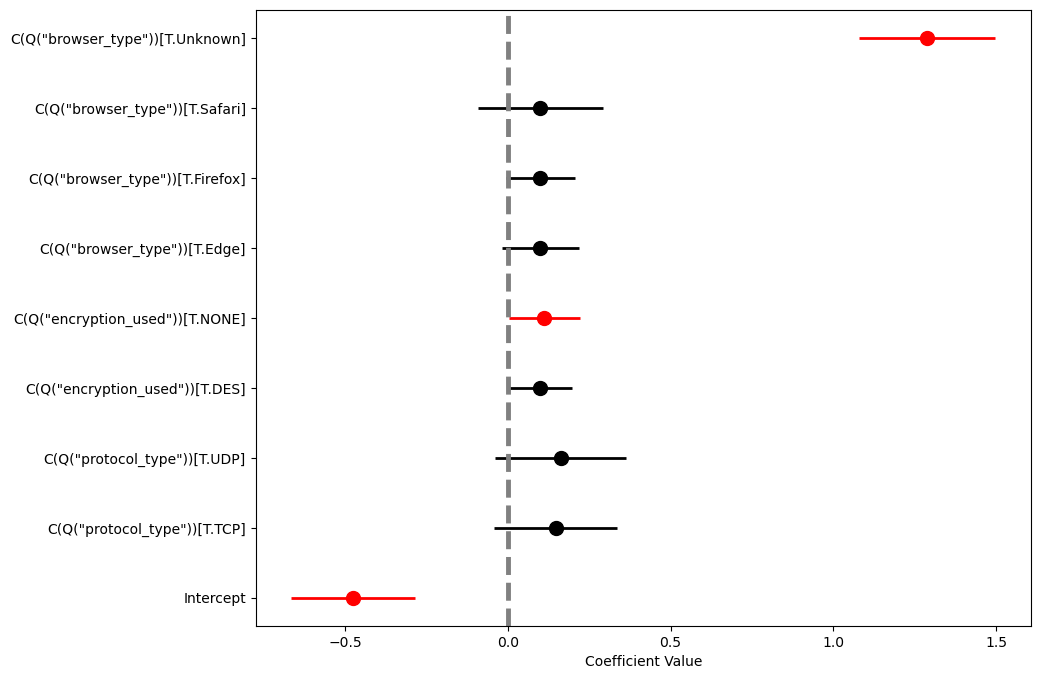

In [180]:
my_coefplot(model_01, zero_nudge=0.1)

### Model 02: Continuous Predictors, Linear Additive

In [181]:
model_02 = smf.logit(formula=formula_list[2], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.541074
         Iterations 6


In [182]:
model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9530
Method:                             MLE   Df Model:                            6
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2130
Time:                          21:40:57   Log-Likelihood:                -5160.2
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.3792      0.121    -36.094      0.000      -4.617      -4.141
Q("network_packet_size") -2.876e-05      0.000     -0.238      0.812      -0.000       0.000
Q("login_attempts")          0.3897      0.014     28.776      0.000       0.363       0.416
Q("session_duration")        0.0001   3.08e-05      3.938      0.000     6.1e-05       0.000
Q("ip_reputation_score")     3.1337      0.141     22.163      0.000       2.857       3.411
Q("failed_logins")           0.9381      0.027     35.110      0.000       0.886       0.990
Q("unusual_time_access")     0.0336      0.067      0.499      0.618      -0.099       0.166
============================================================================================
"""

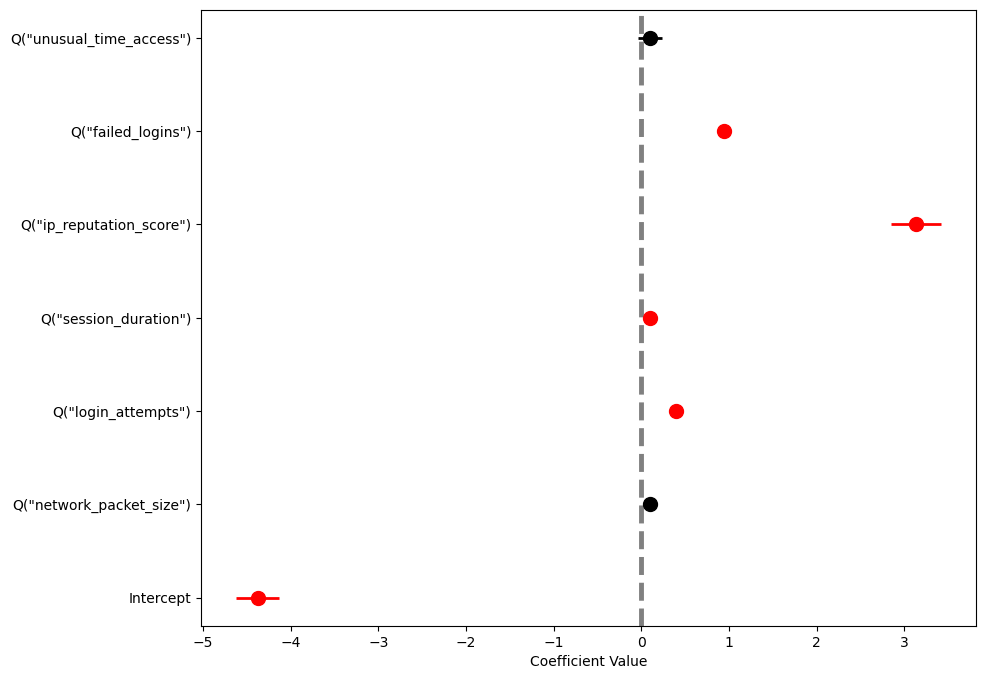

In [183]:
my_coefplot(model_02, zero_nudge=0.1)

### Model 03: Continuous Predictors + Categorical (Additive)

In [184]:
model_03 = smf.logit(formula=formula_list[3], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.527443
         Iterations 6


In [185]:
model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9522
Method:                             MLE   Df Model:                           14
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2329
Time:                          21:40:58   Log-Likelihood:                -5030.2
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.7946      0.166    -28.955      0.000      -5.119      -4.470
C(Q("protocol_type"))[T.TCP]        0.1434      0.110      1.299      0.194      -0.073       0.360
C(Q("protocol_type"))[T.UDP]        0.1125      0.117      0.962      0.336      -0.117       0.342
C(Q("encryption_used"))[T.DES]      0.1112      0.056      1.969      0.049       0.000       0.222
C(Q("encryption_used"))[T.NONE]     0.1628      0.064      2.548      0.011       0.038       0.288
C(Q("browser_type"))[T.Edge]        0.0409      0.070      0.583      0.560      -0.097       0.178
C(Q("browser_type"))[T.Firefox]     0.0429      0.063      0.681      0.496      -0.081       0.166
C(Q("browser_type"))[T.Safari]     -0.0832      0.113     -0.737      0.461      -0.304       0.138
C(Q("browser_type"))[T.Unknown]     1.7848      0.121     14.698      0.000       1.547       2.023
Q("network_packet_size")         -4.82e-05      0.000     -0.393      0.694      -0.000       0.000
Q("login_attempts")                 0.4014      0.014     29.107      0.000       0.374       0.428
Q("session_duration")               0.0001   3.12e-05      3.832      0.000    5.83e-05       0.000
Q("ip_reputation_score")            3.2326      0.144     22.480      0.000       2.951       3.514
Q("failed_logins")                  0.9680      0.027     35.457      0.000       0.914       1.021
Q("unusual_time_access")            0.0501      0.069      0.731      0.465      -0.084       0.184
===================================================================================================
"""

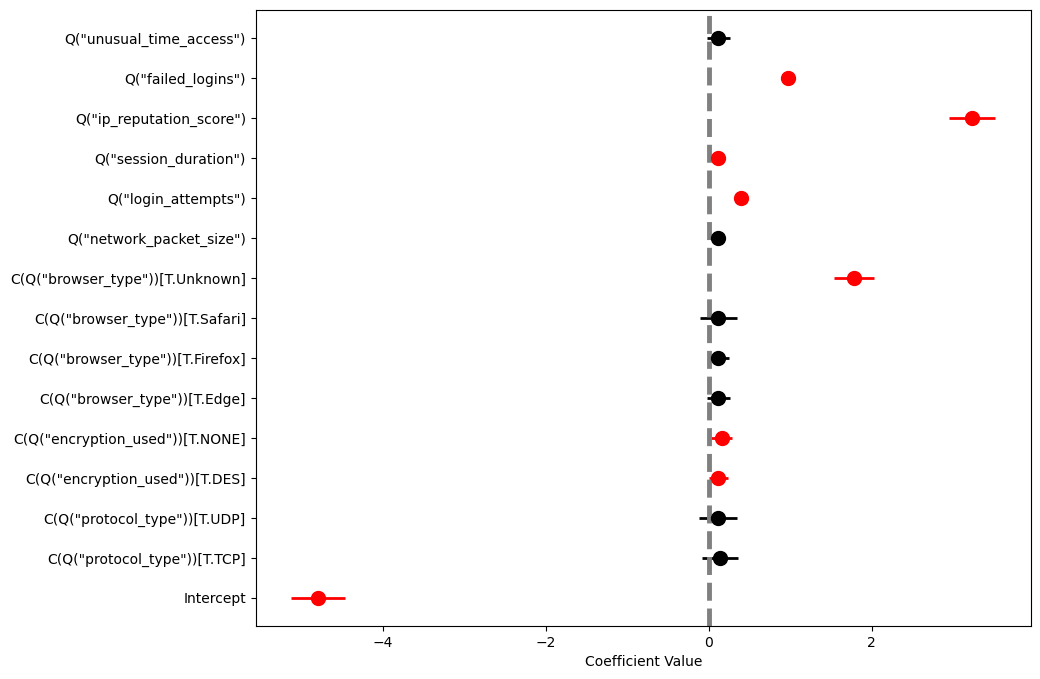

In [186]:
my_coefplot(model_03, zero_nudge=0.12)

### Model 04: Continuous Predictors with Pairwise Interactions and Quadratic Terms

In [187]:
model_04 = smf.logit(formula=formula_list[4], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.508982
         Iterations 7


In [188]:
model_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9524
Method:                             MLE   Df Model:                           12
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2597
Time:                          21:40:58   Log-Likelihood:                -4854.2
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                         -2.1352      0.244     -8.737      0.000      -2.614      -1.656
Q("network_packet_size")                          -0.0003      0.001     -0.444      0.657      -0.001       0.001
Q("login_attempts")                               -0.9843      0.073    -13.547      0.000      -1.127      -0.842
Q("session_duration")                           1.497e-05      0.000      0.115      0.908      -0.000       0.000
Q("ip_reputation_score")                           3.3917      0.146     23.171      0.000       3.105       3.679
Q("failed_logins")                                 0.9973      0.028     35.564      0.000       0.942       1.052
Q("unusual_time_access")                           0.0299      0.070      0.428      0.669      -0.107       0.167
Q("network_packet_size"):Q("login_attempts")    3.528e-05   7.28e-05      0.485      0.628      -0.000       0.000
Q("network_packet_size"):Q("session_duration")  8.394e-08   1.59e-07      0.530      0.596   -2.27e-07    3.95e-07
Q("login_attempts"):Q("session_duration")      -2.501e-05   1.89e-05     -1.323      0.186   -6.21e-05     1.2e-05
I(Q("network_packet_size") ** 2)               -1.397e-08   4.65e-07     -0.030      0.976   -9.24e-07    8.96e-07
I(Q("login_attempts") ** 2)                        0.1668      0.008     21.749      0.000       0.152       0.182
I(Q("session_duration") ** 2)                   5.101e-08   2.22e-08      2.300      0.021    7.55e-09    9.45e-08
==================================================================================================================
"""

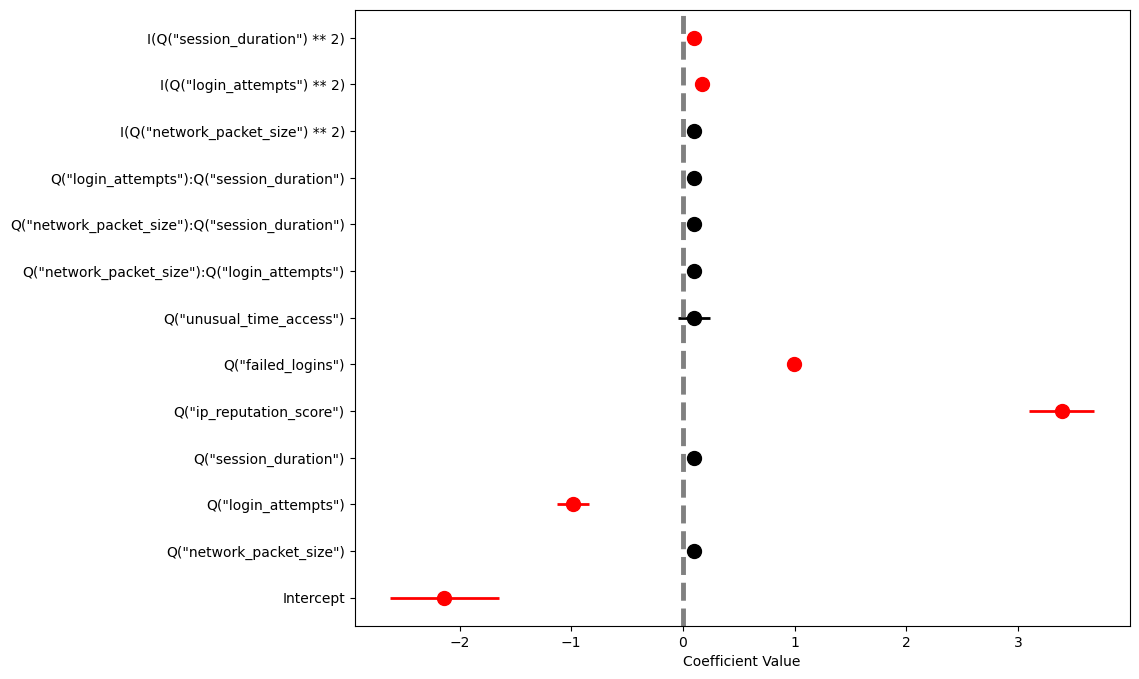

In [189]:
my_coefplot(model_04, zero_nudge=0.1)

### Model 05: Categorical Interacting with All Continuous Predictors

In [190]:
model_05 = smf.logit(formula=formula_list[5], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.527220
         Iterations 6


In [191]:
model_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9510
Method:                             MLE   Df Model:                           26
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2332
Time:                          21:40:58   Log-Likelihood:                -5028.1
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -5.0976      0.571     -8.927      0.000      -6.217      -3.978
C(Q("protocol_type"))[T.TCP]                              0.5433      0.588      0.925      0.355      -0.609       1.695
C(Q("protocol_type"))[T.UDP]                              0.1749      0.624      0.280      0.779      -1.049       1.399
C(Q("encryption_used"))[T.DES]                            0.1119      0.057      1.979      0.048       0.001       0.223
C(Q("encryption_used"))[T.NONE]                           0.1631      0.064      2.551      0.011       0.038       0.288
C(Q("browser_type"))[T.Edge]                              0.0419      0.070      0.598      0.550      -0.096       0.179
C(Q("browser_type"))[T.Firefox]                           0.0458      0.063      0.727      0.467      -0.078       0.169
C(Q("browser_type"))[T.Safari]                           -0.0820      0.113     -0.726      0.468      -0.303       0.139
C(Q("browser_type"))[T.Unknown]                           1.7838      0.122     14.672      0.000       1.546       2.022
Q("network_packet_size")                                  0.0001      0.001      0.258      0.797      -0.001       0.001
C(Q("protocol_type"))[T.TCP]:Q("network_packet_size")    -0.0002      0.001     -0.416      0.677      -0.001       0.001
C(Q("protocol_type"))[T.UDP]:Q("network_packet_size") -7.837e-05      0.001     -0.129      0.897      -0.001       0.001
Q("login_attempts")                                       0.4367      0.060      7.232      0.000       0.318       0.555
C(Q("protocol_type"))[T.TCP]:Q("login_attempts")         -0.0494      0.063     -0.790      0.430      -0.172       0.073
C(Q("protocol_type"))[T.UDP]:Q("login_attempts")         -0.0027      0.067     -0.041      0.967      -0.133       0.128
Q("session_duration")                                  8.273e-05      0.000      0.587      0.557      -0.000       0.000
C(Q("protocol_type"))[T.TCP]:Q("session_duration")     3.176e-05      0.000      0.218      0.828      -0.000       0.000
C(Q("protocol_type"))[T.UDP]:Q("session_duration")     5.888e-05      0.000      0.381      0.703      -0.000       0.000
Q("ip_reputation_score")                                  3.1719      0.649      4.885      0.000       1.899       4.445
C(Q("protocol_type"))[T.TCP]:Q("ip_reputation_score")     0.0068      0.671      0.010      0.992      -1.309       1.323
C(Q("protocol_type"))[T.UDP]:Q("ip_reputation_score")     0.2233      0.711      0.314      0.753      -1.170       1.617
Q("failed_logins")                                        1.0450      0.124      8.410      0.000       0.801       1.289
C(Q("protocol_type"))[T.TCP]:Q("failed_logins")          -0.0751      0.128     -0.585      0.558      -0.327       0.176
C(Q("protocol_type"))[T.UDP]:Q("failed_logins")    

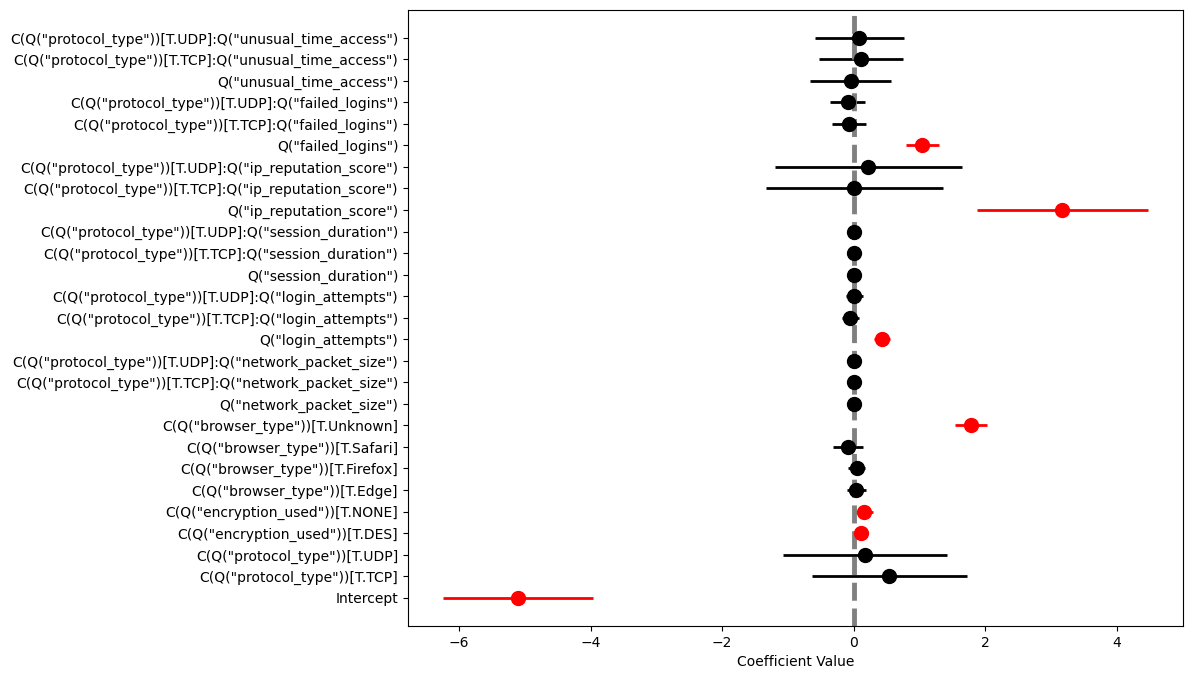

In [192]:
my_coefplot(model_05, zero_nudge=.01)

### Model 06: Higher-Order Polynomials on Session Duration

In [193]:
model_06 = smf.logit(formula=formula_list[6], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.526618
         Iterations 6


In [194]:
model_06.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9520
Method:                             MLE   Df Model:                           16
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2341
Time:                          21:40:59   Log-Likelihood:                -5022.4
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.6575      0.169    -27.577      0.000      -4.988      -4.326
C(Q("protocol_type"))[T.TCP]        0.1414      0.111      1.278      0.201      -0.075       0.358
C(Q("protocol_type"))[T.UDP]        0.1098      0.117      0.938      0.348      -0.120       0.339
C(Q("encryption_used"))[T.DES]      0.1116      0.057      1.973      0.048       0.001       0.222
C(Q("encryption_used"))[T.NONE]     0.1675      0.064      2.619      0.009       0.042       0.293
C(Q("browser_type"))[T.Edge]        0.0422      0.070      0.601      0.548      -0.095       0.180
C(Q("browser_type"))[T.Firefox]     0.0412      0.063      0.655      0.513      -0.082       0.165
C(Q("browser_type"))[T.Safari]     -0.0723      0.113     -0.640      0.522      -0.294       0.149
C(Q("browser_type"))[T.Unknown]     1.7882      0.122     14.705      0.000       1.550       2.027
Q("network_packet_size")        -5.159e-05      0.000     -0.420      0.674      -0.000       0.000
Q("login_attempts")                 0.4022      0.014     29.121      0.000       0.375       0.429
Q("session_duration")              -0.0003      0.000     -2.816      0.005      -0.001      -0.000
I(Q("session_duration") ** 2)    2.446e-07   6.69e-08      3.656      0.000    1.13e-07    3.76e-07
I(Q("session_duration") ** 3)   -2.721e-11   8.81e-12     -3.087      0.002   -4.45e-11   -9.93e-12
Q("ip_reputation_score")            3.2399      0.144     22.495      0.000       2.958       3.522
Q("failed_logins")                  0.9699      0.027     35.456      0.000       0.916       1.023
Q("unusual_time_access")            0.0489      0.069      0.713      0.476      -0.085       0.183
===================================================================================================
"""

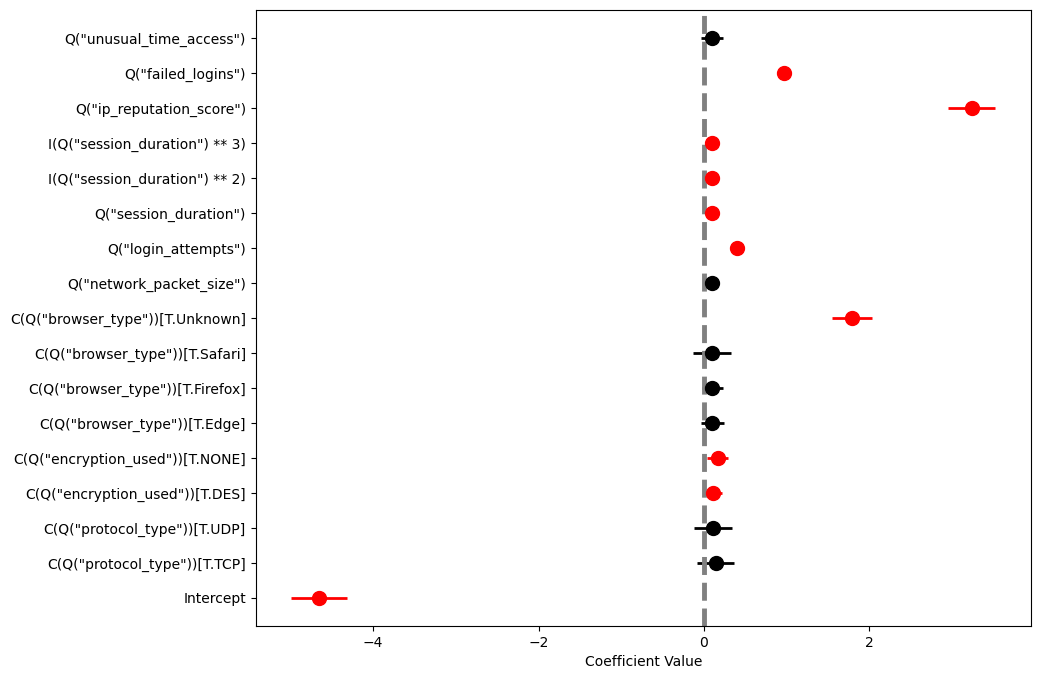

In [195]:
my_coefplot(model_06, zero_nudge=.1)

### Model 07: All Predictors, Continuous Interactions, and Categorical (Full Candidate)

In [196]:
model_07 = smf.logit(formula=formula_list[7], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.504150
         Iterations 7


In [197]:
model_07.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9507
Method:                             MLE   Df Model:                           29
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2667
Time:                          21:40:59   Log-Likelihood:                -4808.1
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -8.4044      0.396    -21.208      0.000      -9.181      -7.628
C(Q("protocol_type"))[T.TCP]                          0.1686      0.113      1.488      0.137      -0.053       0.391
C(Q("protocol_type"))[T.UDP]                          0.1239      0.120      1.034      0.301      -0.111       0.359
C(Q("encryption_used"))[T.DES]                        0.1144      0.058      1.976      0.048       0.001       0.228
C(Q("encryption_used"))[T.NONE]                       0.1737      0.066      2.646      0.008       0.045       0.302
C(Q("browser_type"))[T.Edge]                          0.0366      0.072      0.509      0.611      -0.104       0.177
C(Q("browser_type"))[T.Firefox]                       0.0324      0.064      0.503      0.615      -0.094       0.158
C(Q("browser_type"))[T.Safari]                       -0.0737      0.115     -0.643      0.520      -0.298       0.151
C(Q("browser_type"))[T.Unknown]                       2.0083      0.133     15.140      0.000       1.748       2.268
Q("network_packet_size")                             -0.0010      0.001     -1.769      0.077      -0.002       0.000
Q("login_attempts")                                   1.0387      0.056     18.562      0.000       0.929       1.148
Q("session_duration")                                 0.0003      0.000      1.693      0.091   -4.01e-05       0.001
Q("ip_reputation_score")                              8.8086      0.612     14.401      0.000       7.610      10.007
Q("failed_logins")                                    2.5563      0.120     21.375      0.000       2.322       2.791
Q("unusual_time_access")                             -0.0774      0.361     -0.214      0.830      -0.785       0.631
Q("network_packet_size"):Q("login_attempts")       6.889e-05   6.93e-05      0.994      0.320    -6.7e-05       0.000
Q("network_packet_size"):Q("session_duration")     1.024e-07   1.57e-07      0.653      0.514   -2.05e-07    4.09e-07
Q("network_packet_size"):Q("ip_reputation_score")     0.0013      0.001      1.755      0.079      -0.000       0.003
Q("network_packet_size"):Q("failed_logins")         6.04e-05      0.000      0.438      0.661      -0.000       0.000
Q("network_packet_size"):Q("unusual_time_access")    -0.0003      0.000     -0.772      0.440      -0.001       0.000
Q("login_attempts"):Q("session_duration")         -3.094e-05   1.68e-05     -1.844      0.065   -6.38e-05    1.94e-06
Q("login_attempts"):Q("ip_reputation_score")         -0.7947      0.080     -9.975      0.000      -0.951      -0.639
Q("login_attempts"):Q("failed_logins")               -0.2263      0.014    -15.642      0.000      -0.255      -0.198
Q("login_attempts"):Q("unusual_time_access")         -0.0162      0.039     -0.413      0.680      -0.093       0.061
Q("session_duration"):Q("ip_reputatio

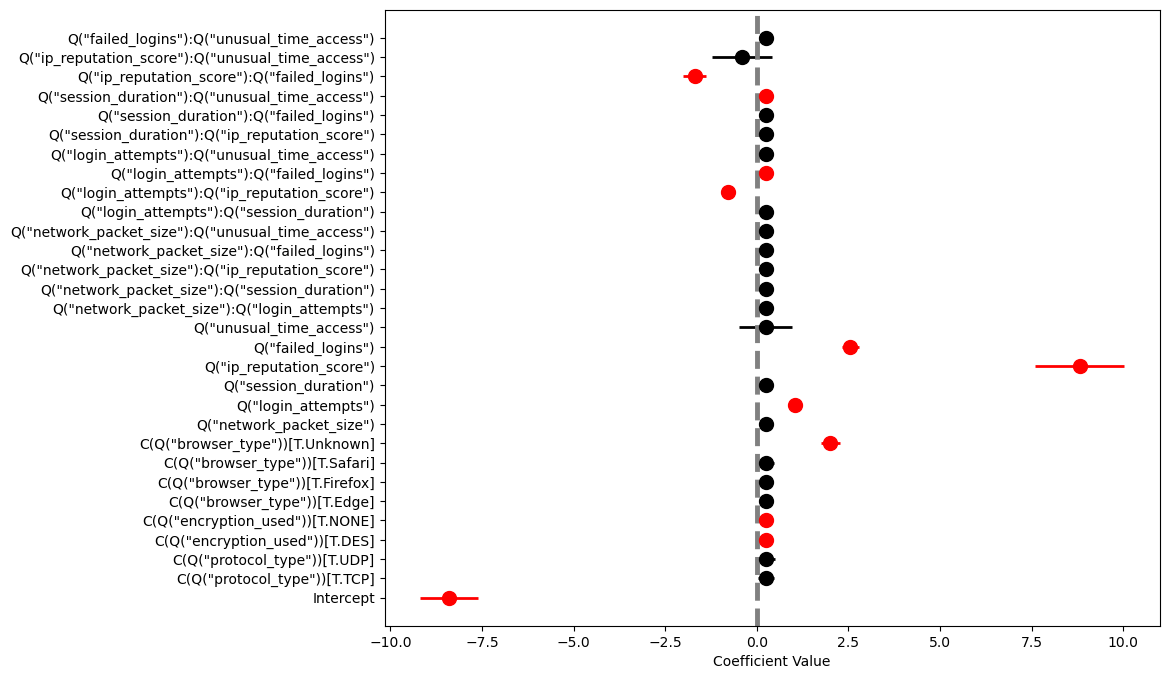

In [198]:
my_coefplot(model_07, zero_nudge=0.25)

### Model 08: Final Model (IP Reputation Score Slope Varies by Protocol Type)

In [199]:
model_08 = smf.logit(formula=formula_list[8], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.527425
         Iterations 6


In [200]:
model_08.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9520
Method:                             MLE   Df Model:                           16
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2329
Time:                          21:40:59   Log-Likelihood:                -5030.1
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                -4.7464      0.260    -18.256      0.000      -5.256      -4.237
C(Q("protocol_type"))[T.TCP]                              0.1079      0.241      0.449      0.654      -0.364       0.579
C(Q("protocol_type"))[T.UDP]                              0.0167      0.256      0.065      0.948      -0.486       0.519
C(Q("encryption_used"))[T.DES]                            0.1113      0.056      1.970      0.049       0.001       0.222
C(Q("encryption_used"))[T.NONE]                           0.1625      0.064      2.544      0.011       0.037       0.288
C(Q("browser_type"))[T.Edge]                              0.0406      0.070      0.579      0.563      -0.097       0.178
C(Q("browser_type"))[T.Firefox]                           0.0426      0.063      0.676      0.499      -0.081       0.166
C(Q("browser_type"))[T.Safari]                           -0.0848      0.113     -0.751      0.453      -0.306       0.136
C(Q("browser_type"))[T.Unknown]                           1.7835      0.121     14.683      0.000       1.545       2.022
Q("ip_reputation_score")                                  3.0860      0.625      4.934      0.000       1.860       4.312
Q("ip_reputation_score"):C(Q("protocol_type"))[T.TCP]     0.1081      0.647      0.167      0.867      -1.160       1.376
Q("ip_reputation_score"):C(Q("protocol_type"))[T.UDP]     0.2829      0.685      0.413      0.679      -1.059       1.625
Q("network_packet_size")                              -4.836e-05      0.000     -0.394      0.694      -0.000       0.000
Q("login_attempts")                                       0.4014      0.014     29.109      0.000       0.374       0.428
Q("session_duration")                                     0.0001   3.12e-05      3.830      0.000    5.83e-05       0.000
Q("failed_logins")                                        0.9682      0.027     35.457      0.000       0.915       1.022
Q("unusual_time_access")                                  0.0505      0.069      0.736      0.462      -0.084       0.185
=========================================================================================================================
"""

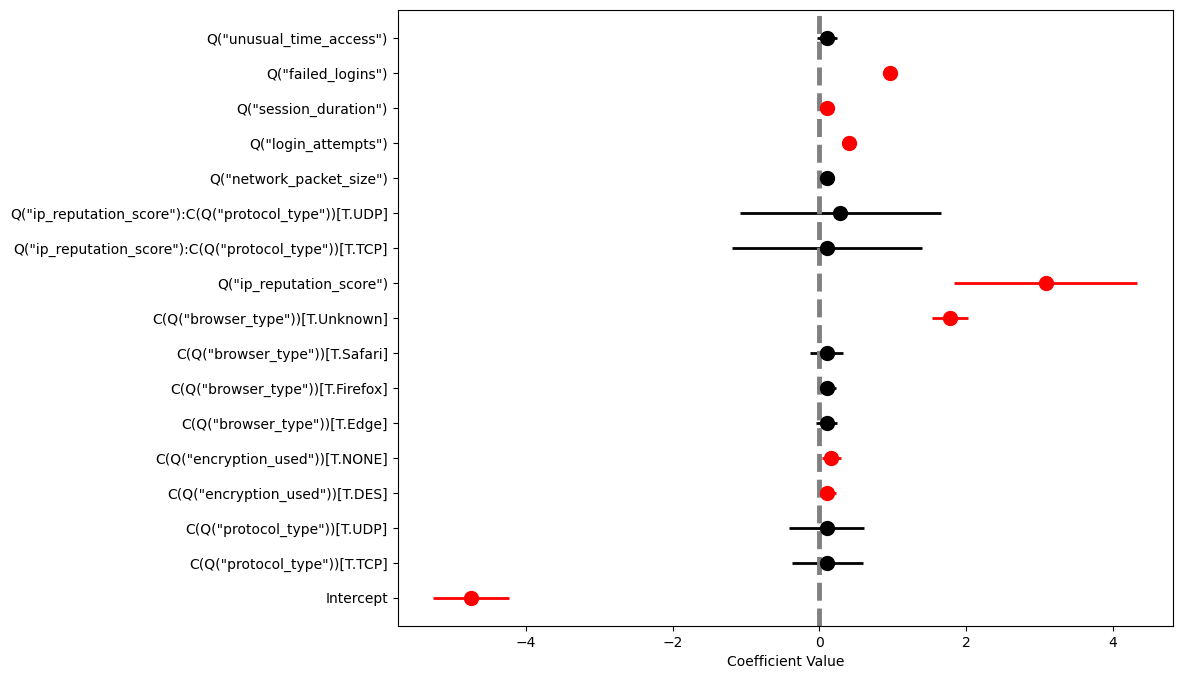

In [201]:
my_coefplot(model_08, zero_nudge=0.1)

### Model 09: Target on login_attempts, failed_logins, and ip_reputation_score (Additive)

In [202]:
model_09 = smf.logit(formula=formula_list[9], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.541911
         Iterations 6


In [203]:
model_09.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9533
Method:                             MLE   Df Model:                            3
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2118
Time:                          21:41:00   Log-Likelihood:                -5168.2
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.2876      0.101    -42.574      0.000      -4.485      -4.090
Q("login_attempts")          0.3894      0.014     28.770      0.000       0.363       0.416
Q("failed_logins")           0.9380      0.027     35.143      0.000       0.886       0.990
Q("ip_reputation_score")     3.1226      0.141     22.127      0.000       2.846       3.399
============================================================================================
"""

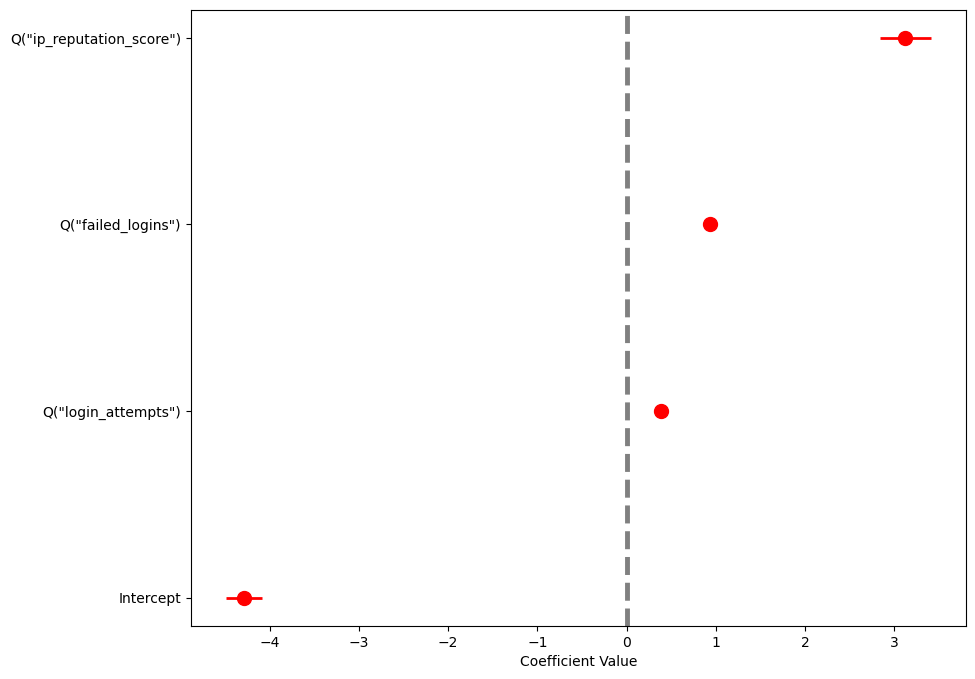

In [204]:
my_coefplot(model_09, zero_nudge=0.1)

### Model 10: Target on login_attempts, failed_logins, and ip_reputation_score (Interactions)

In [205]:
model_10 = smf.logit(formula=formula_list[10], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.522628
         Iterations 6


In [206]:
model_10.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9530
Method:                             MLE   Df Model:                            6
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.2399
Time:                          21:41:00   Log-Likelihood:                -4984.3
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       -7.8757      0.239    -32.892      0.000      -8.345      -7.406
Q("login_attempts")                              0.9916      0.041     24.379      0.000       0.912       1.071
Q("failed_logins")                               2.4140      0.092     26.115      0.000       2.233       2.595
Q("ip_reputation_score")                         8.8440      0.457     19.354      0.000       7.948       9.740
Q("login_attempts"):Q("failed_logins")          -0.2138      0.014    -15.048      0.000      -0.242      -0.186
Q("login_attempts"):Q("ip_reputation_score")    -0.7520      0.078     -9.601      0.000      -0.905      -0.598
Q("failed_logins"):Q("ip_reputation_score")     -1.6015      0.152    -10.539      0.000      -1.899      -1.304
================================================================================================================
"""

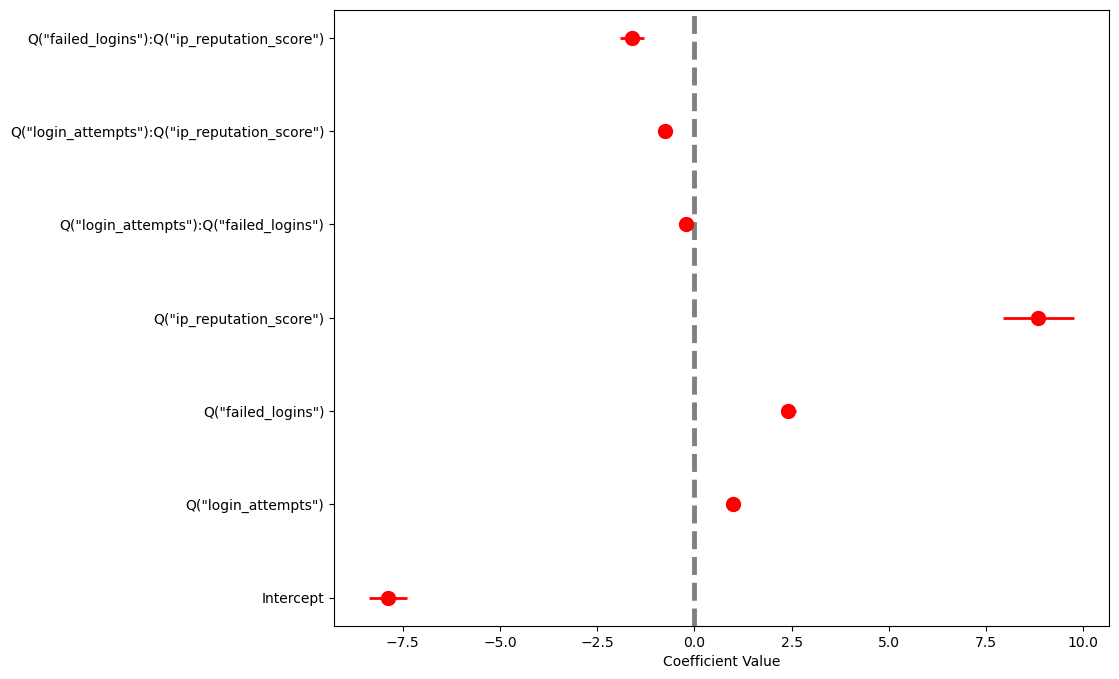

In [207]:
my_coefplot(model_10, zero_nudge=0.1)

### Model 11: Quadratic terms for login_attempts, failed_logins, ip_reputation_score

In [208]:
model_11 = smf.logit(formula=formula_list[11], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.420042
         Iterations 7


In [209]:
model_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9530
Method:                             MLE   Df Model:                            6
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.3891
Time:                          21:41:00   Log-Likelihood:                -4005.9
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.0307      0.167      6.163      0.000       0.703       1.358
Q("login_attempts")                 -1.0866      0.068    -15.917      0.000      -1.220      -0.953
Q("failed_logins")                  -2.0037      0.096    -20.960      0.000      -2.191      -1.816
Q("ip_reputation_score")           -10.3730      0.647    -16.030      0.000     -11.641      -9.105
I(Q("login_attempts") ** 2)          0.1846      0.008     21.841      0.000       0.168       0.201
I(Q("failed_logins") ** 2)           1.0558      0.035     29.787      0.000       0.986       1.125
I(Q("ip_reputation_score") ** 2)    19.5921      0.911     21.512      0.000      17.807      21.377
====================================================================================================
"""

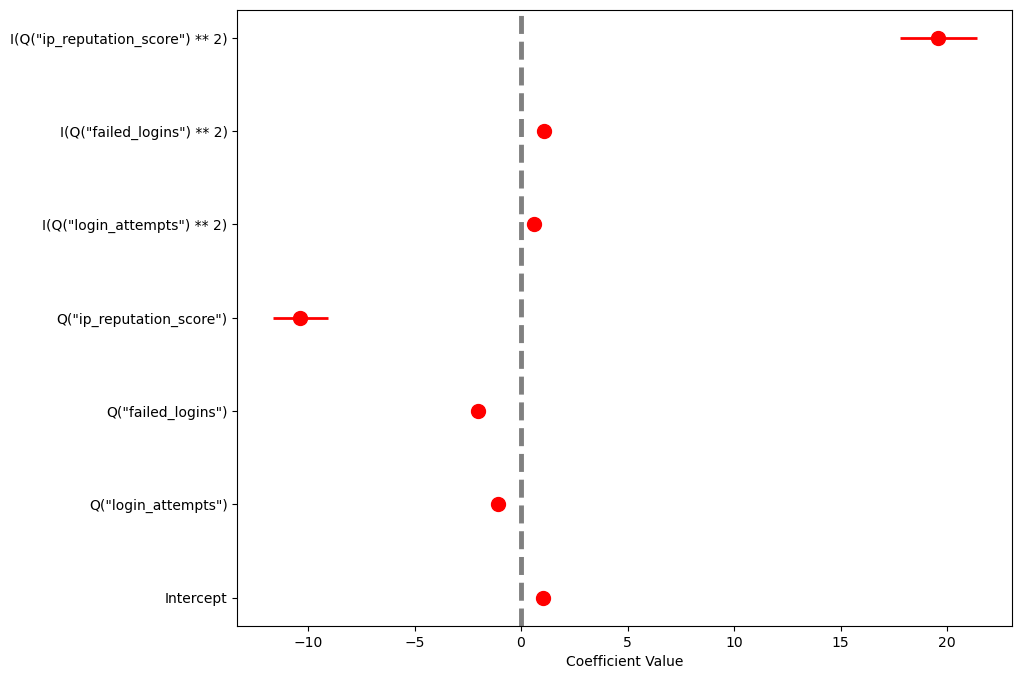

In [210]:
my_coefplot(model_11, zero_nudge=0.6)

### Model 12: Cubic terms for login_attempts, failed_logins, ip_reputation_score

In [211]:
model_12 = smf.logit(formula=formula_list[12], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.395827
         Iterations 8


In [212]:
model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9530
Method:                             MLE   Df Model:                            6
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.4243
Time:                          21:41:00   Log-Likelihood:                -3775.0
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.2938      0.146      2.015      0.044       0.008       0.580
Q("login_attempts")                 -0.5111      0.042    -12.045      0.000      -0.594      -0.428
Q("failed_logins")                  -1.1124      0.066    -16.880      0.000      -1.242      -0.983
Q("ip_reputation_score")            -5.4226      0.412    -13.168      0.000      -6.230      -4.615
I(Q("login_attempts") ** 3)          0.0166      0.001     21.927      0.000       0.015       0.018
I(Q("failed_logins") ** 3)           0.2823      0.010     28.696      0.000       0.263       0.302
I(Q("ip_reputation_score") ** 3)    20.5361      0.930     22.076      0.000      18.713      22.359
====================================================================================================
"""

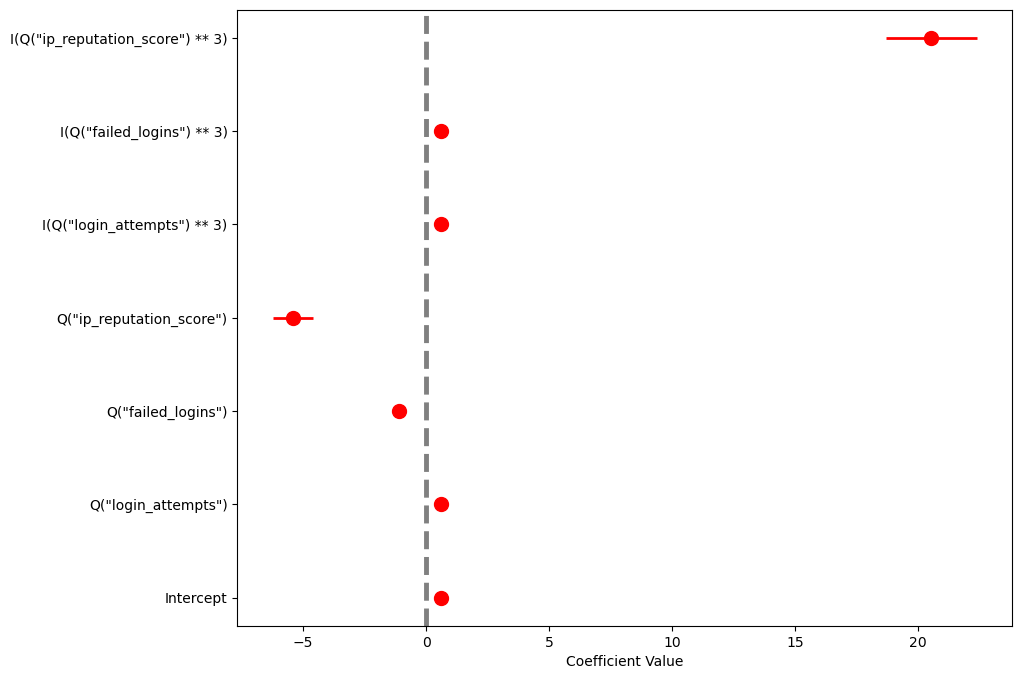

In [213]:
my_coefplot(model_12, zero_nudge=0.6)

### Model 13: Quartic terms for login_attempts, failed_logins, ip_reputation_score

In [214]:
model_13 = smf.logit(formula=formula_list[13], 
                     data=df). \
                     fit()

Optimization terminated successfully.
         Current function value: 0.379797
         Iterations 9


In [215]:
model_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9530
Method:                             MLE   Df Model:                            6
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.4476
Time:                          21:41:00   Log-Likelihood:                -3622.1
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.1390      0.136     -1.019      0.308      -0.406       0.128
Q("login_attempts")                 -0.3186      0.034     -9.286      0.000      -0.386      -0.251
Q("failed_logins")                  -0.7456      0.057    -13.187      0.000      -0.856      -0.635
Q("ip_reputation_score")            -3.7034      0.338    -10.963      0.000      -4.365      -3.041
I(Q("login_attempts") ** 4)          0.0020   9.25e-05     21.673      0.000       0.002       0.002
I(Q("failed_logins") ** 4)           0.0907      0.004     24.803      0.000       0.084       0.098
I(Q("ip_reputation_score") ** 4)    27.7619      1.269     21.870      0.000      25.274      30.250
====================================================================================================
"""

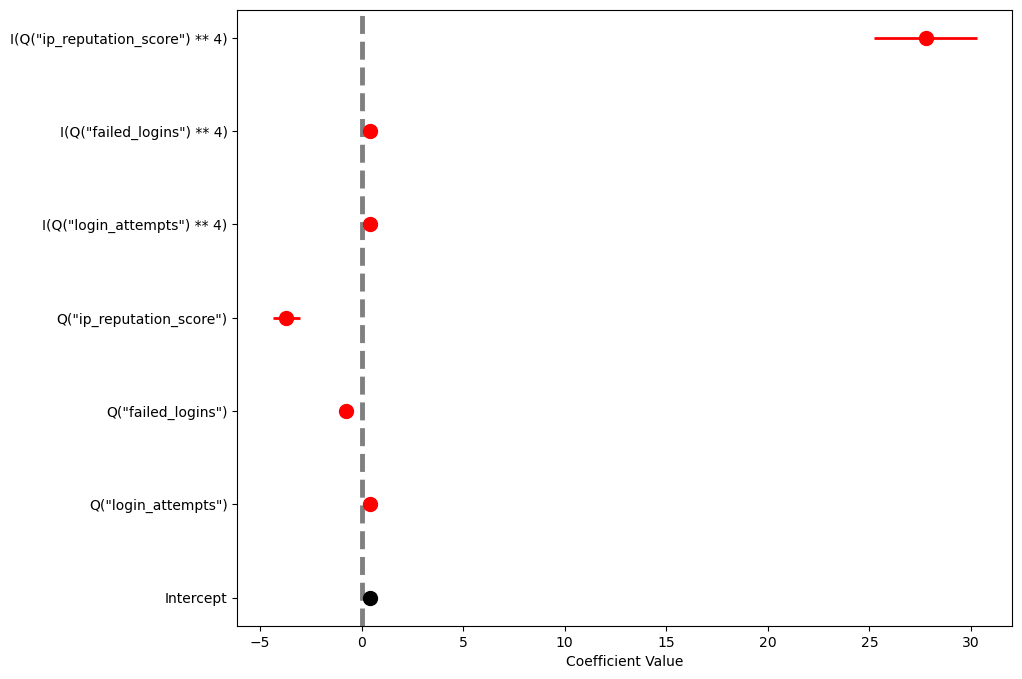

In [216]:
my_coefplot(model_13, zero_nudge=0.4)

### Compare Fitted Models - Training Data

In [217]:
logit_results_list = []

for model in range(len(formula_list)):
    logit_results_list.append(fit_and_assess_logit('attack_detected',
                                                   model,
                                                   formula_list[model],
                                                   df))

Optimization terminated successfully.
         Current function value: 0.687540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541911
  

In [218]:
logit_results_df = pd.concat(logit_results_list, 
                             ignore_index=True)

#### We see model 13 w/ 7 coefs has a 0.85 accuracy.

In [219]:
logit_results_df

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,"Q(""attack_detected"") ~ 1",1,0.5,0.552899,0.000000,1.000000,0.000000,0.500000
1,1,"Q(""attack_detected"") ~ C(Q(""protocol_type"")) +...",9,0.5,0.577226,0.086069,0.974398,0.025602,0.544706
2,2,"Q(""attack_detected"") ~ Q(""network_packet_size""...",7,0.5,0.728531,0.655253,0.787787,0.212213,0.793341
3,3,"Q(""attack_detected"") ~ Q(""network_packet_size""...",15,0.5,0.742791,0.670732,0.801062,0.198938,0.805999
4,4,"Q(""attack_detected"") ~ Q(""network_packet_size""...",13,0.5,0.758519,0.673780,0.827043,0.172957,0.815928
5,5,"Q(""attack_detected"") ~ C(Q(""protocol_type"")) *...",27,0.5,0.742162,0.671201,0.799545,0.200455,0.806172
6,6,"Q(""attack_detected"") ~ Q(""network_packet_size""...",17,0.5,0.742057,0.669325,0.800872,0.199128,0.806774
7,7,"Q(""attack_detected"") ~ (Q(""network_packet_size...",30,0.5,0.778127,0.760553,0.792338,0.207662,0.848402
8,8,"Q(""attack_detected"") ~ Q(""ip_reputation_score""...",17,0.5,0.741952,0.670263,0.799924,0.200076,0.805972
9,9,"Q(""attack_detected"") ~ Q(""login_attempts"") + Q...",4,0.5,0.729684,0.656660,0.788735,0.211265,0.792637


In [220]:
model_13.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     Q("attack_detected")   No. Observations:                 9537
Model:                            Logit   Df Residuals:                     9530
Method:                             MLE   Df Model:                            6
Date:                  Tue, 02 Sep 2025   Pseudo R-squ.:                  0.4476
Time:                          21:41:01   Log-Likelihood:                -3622.1
converged:                         True   LL-Null:                       -6557.1
Covariance Type:              nonrobust   LLR p-value:                     0.000
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -0.1390      0.136     -1.019      0.308      -0.406       0.128
Q("login_attempts")                 -0.3186      0.034     -9.286      0.000      -0.386      -0.251
Q("failed_logins")                  -0.7456      0.057    -13.187      0.000      -0.856      -0.635
Q("ip_reputation_score")            -3.7034      0.338    -10.963      0.000      -4.365      -3.041
I(Q("login_attempts") ** 4)          0.0020   9.25e-05     21.673      0.000       0.002       0.002
I(Q("failed_logins") ** 4)           0.0907      0.004     24.803      0.000       0.084       0.098
I(Q("ip_reputation_score") ** 4)    27.7619      1.269     21.870      0.000      25.274      30.250
====================================================================================================
"""

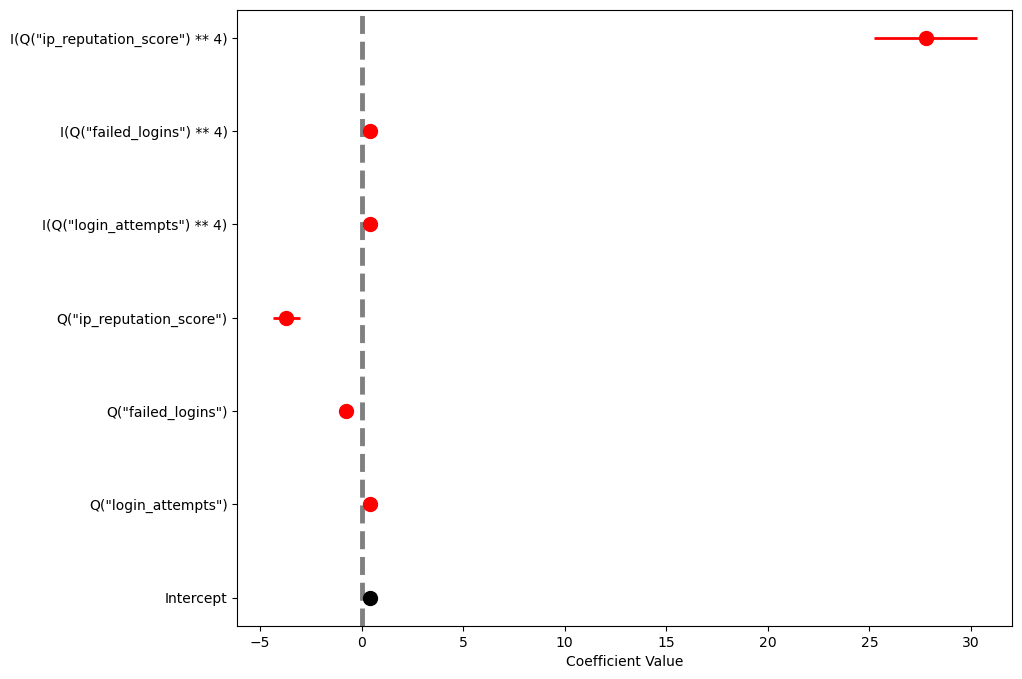

In [221]:
my_coefplot(model_13, zero_nudge=0.4)

## Fit Linear Regression Models w/ Cross-Validation - Test Data

### Functions

In [224]:
def logistic_regression_cross_val_score(model, 
                                        formula, 
                                        init_model, 
                                        df, 
                                        cv):
    """
    Perform cross-validated evaluation of a logistic-style model using a Patsy formula.

    This function builds design matrices from `formula` and `df` using patsy.dmatrices,
    then runs cross-validation using sklearn.model_selection.cross_val_score to compute per-fold
    accuracy scores. The per-fold results and some metadata are returned as a pandas DataFrame.

    Parameters
    ----------
    model : str
        A human-readable name for the model; stored in the returned DataFrame.
    formula : str
        A Patsy-compatible formula string (e.g. "y ~ x1 + x2 + C(group)") used to create y and X.
    init_model : object
        An unfitted scikit-learn-style estimator (must implement fit/predict and be compatible with
        sklearn.model_selection.cross_val_score). Example: LinearRegression().
    df : pandas.DataFrame
        DataFrame containing all variables referenced in `formula`.
    cv : int or cross-validation splitter
        Number of folds (int) or a cross-validation splitter instance passed to cross_val_score.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with one row per CV fold containing:
        - 'R-squared' : R^2 score on the test fold (from cross_val_score default scoring)
        - 'RMSE' : Root mean squared error on the test fold
        - 'fold_id' : 1-based fold identifier
        - 'model_name' : the provided `model`
        - 'model_formula' : the provided `formula`
        - 'num_coefs' : number of columns in the design matrix X
    """
    # Create the feature and output arrays using the formula
    y, X = dmatrices(formula, data=df)
    
    # Train and test within each fold - return the test set scores
    test_accuracy = cross_val_score(init_model, 
                                    X, 
                                    y.ravel(), 
                                    cv=cv)
    
    # Extract model metrics
    results_df=pd.DataFrame({'Accuracy': test_accuracy})
    results_df['fold_id'] = results_df.index + 1
    results_df['model_name'] = model
    results_df['model_formula'] = formula
    results_df['num_coefs'] = X.shape[1]

    # Return the results DataFrame
    return results_df

In [247]:
def fit_logistic_make_roc(y,
                          model, 
                          formula, 
                          df):
    """
    Fit a logistic regression model using a formula interface and return a DataFrame
    containing ROC curve data (true positive rate, false positive rate, and thresholds),
    annotated with model metadata.

    Parameters
    ----------
    y : str
        The name of the target variable.
    model : str
        A human-readable name for the model (e.g., "baseline_logit").
    formula : str
        A Patsy/Statsmodels formula string specifying the logistic regression model.
        The left-hand side (response) must be a binary variable (0/1). Example:
        "y ~ x1 + x2 + C(category_var)".
    df : pandas.DataFrame
        The training DataFrame containing all variables referenced in the formula.
        Must include the binary response column named exactly as on the left side
        of `formula`. The response column is assumed here to be named 'y' when
        constructing the ROC curve (see Notes).

    Returns
    -------
    pandas.DataFrame
        A DataFrame with one row per ROC threshold containing:
        - tpr : float
            True positive rate (sensitivity or recall).
        - fpr : float
            False positive rate (1 - specificity).
        - threshold : float
            Decision threshold applied to the predicted probability of the positive class.
        - model_name : str
            Echo of input `model`.
        - model_formula : str
            Echo of input `formula`.
    """
    # Fit the logistic regression model
    a_mod = smf.logit(formula=formula, data=df).fit()

    # Generate predictions
    train_copy = df.copy()
    train_copy['pred_probability'] = a_mod.predict(df)

    # Compute ROC curve
    fpr, tpr, threshold = roc_curve(df[y],
                                    train_copy.pred_probability.to_numpy())

    # Create a DataFrame to hold the ROC curve data
    results_df = pd.DataFrame({'tpr': tpr,
                               'fpr': fpr,
                               'threshold': threshold})

    # Annotate with model metadata
    results_df['model_name'] = model
    results_df['model_formula'] = formula

    # Return the results DataFrame
    return results_df

### Fit w/ Cross-Validation

In [225]:
kf = StratifiedKFold(n_splits=5, 
                     shuffle=True, 
                     random_state=101)

In [226]:
lm = LogisticRegression(penalty=None, 
                        solver='lbfgs', 
                        fit_intercept=False, 
                        max_iter=25001)

### Compare Fitted Models - Test Data

In [ ]:
cv_score_list = []

for model in range(len(formula_list)):
    print('-- Formula ID %d --' % model)
    
    cv_score_list.append(logistic_regression_cross_val_score(model=model, 
                                                             formula=formula_list[model], 
                                                             init_model=lm, 
                                                             df=df, 
                                                             cv=kf))

-- Formula ID 0 --
-- Formula ID 1 --
-- Formula ID 2 --
-- Formula ID 3 --
-- Formula ID 4 --


/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

-- Formula ID 5 --


/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

-- Formula ID 6 --
-- Formula ID 7 --


/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

-- Formula ID 8 --
-- Formula ID 9 --
-- Formula ID 10 --
-- Formula ID 11 --
-- Formula ID 12 --
-- Formula ID 13 --


In [228]:
cv_score_df=pd.concat(cv_score_list, ignore_index=True)

In [229]:
cv_score_df

,Accuracy,fold_id,model_name,model_formula,num_coefs
0,0.552935,1,0,"Q(""attack_detected"") ~ 1",1
1,0.552935,2,0,"Q(""attack_detected"") ~ 1",1
2,0.552701,3,0,"Q(""attack_detected"") ~ 1",1
3,0.552701,4,0,"Q(""attack_detected"") ~ 1",1
4,0.553225,5,0,"Q(""attack_detected"") ~ 1",1
...,...,...,...,...,...
65,0.850629,1,13,"Q(""attack_detected"") ~ Q(""login_attempts"") + Q...",7
66,0.841195,2,13,"Q(""attack_detected"") ~ Q(""login_attempts"") + Q...",7
67,0.848977,3,13,"Q(""attack_detected"") ~ Q(""login_attempts"") + Q...",7
68,0.856843,4,13,"Q(""attack_detected"") ~ Q(""login_attempts"") + Q...",7


In [ ]:
roc_list = []

for model in range(len(formula_list)):
    roc_list.append(fit_logistic_make_roc(y='attack_detected',
                                          model=model, 
                                          formula=formula_list[model], 
                                          df=df))

Optimization terminated successfully.
         Current function value: 0.687540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.541911
  

In [250]:
roc_df = pd.concat(roc_list, ignore_index=True)

In [251]:
roc_df['model_name'] = roc_df.model_name.astype('category')

### Visualize Average Accuracy w/ 1 Standard Error Interval 68% Confidence Interval on the Average

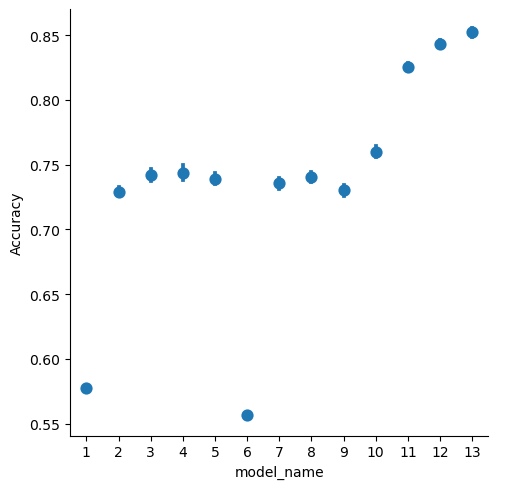

In [230]:
sns.catplot(data=cv_score_df.loc[cv_score_df.model_name > 0, :], 
            x='model_name', 
            y='Accuracy', 
            kind='point', 
            linestyle='none',
            errorbar=('ci', 68))
plt.show()

### Visualize ROC Curves

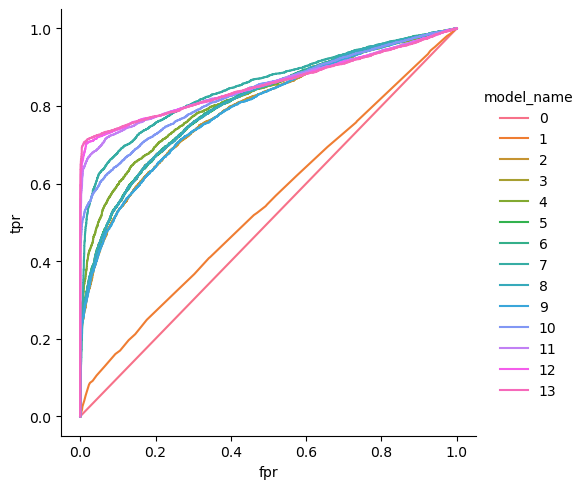

In [ ]:
sns.relplot(data=roc_df.assign(model_name=roc_df.model_name.astype(str)),
            x='fpr', 
            y='tpr',
            hue='model_name',
            kind='line', 
            estimator=None, 
            units='model_name')
plt.show()

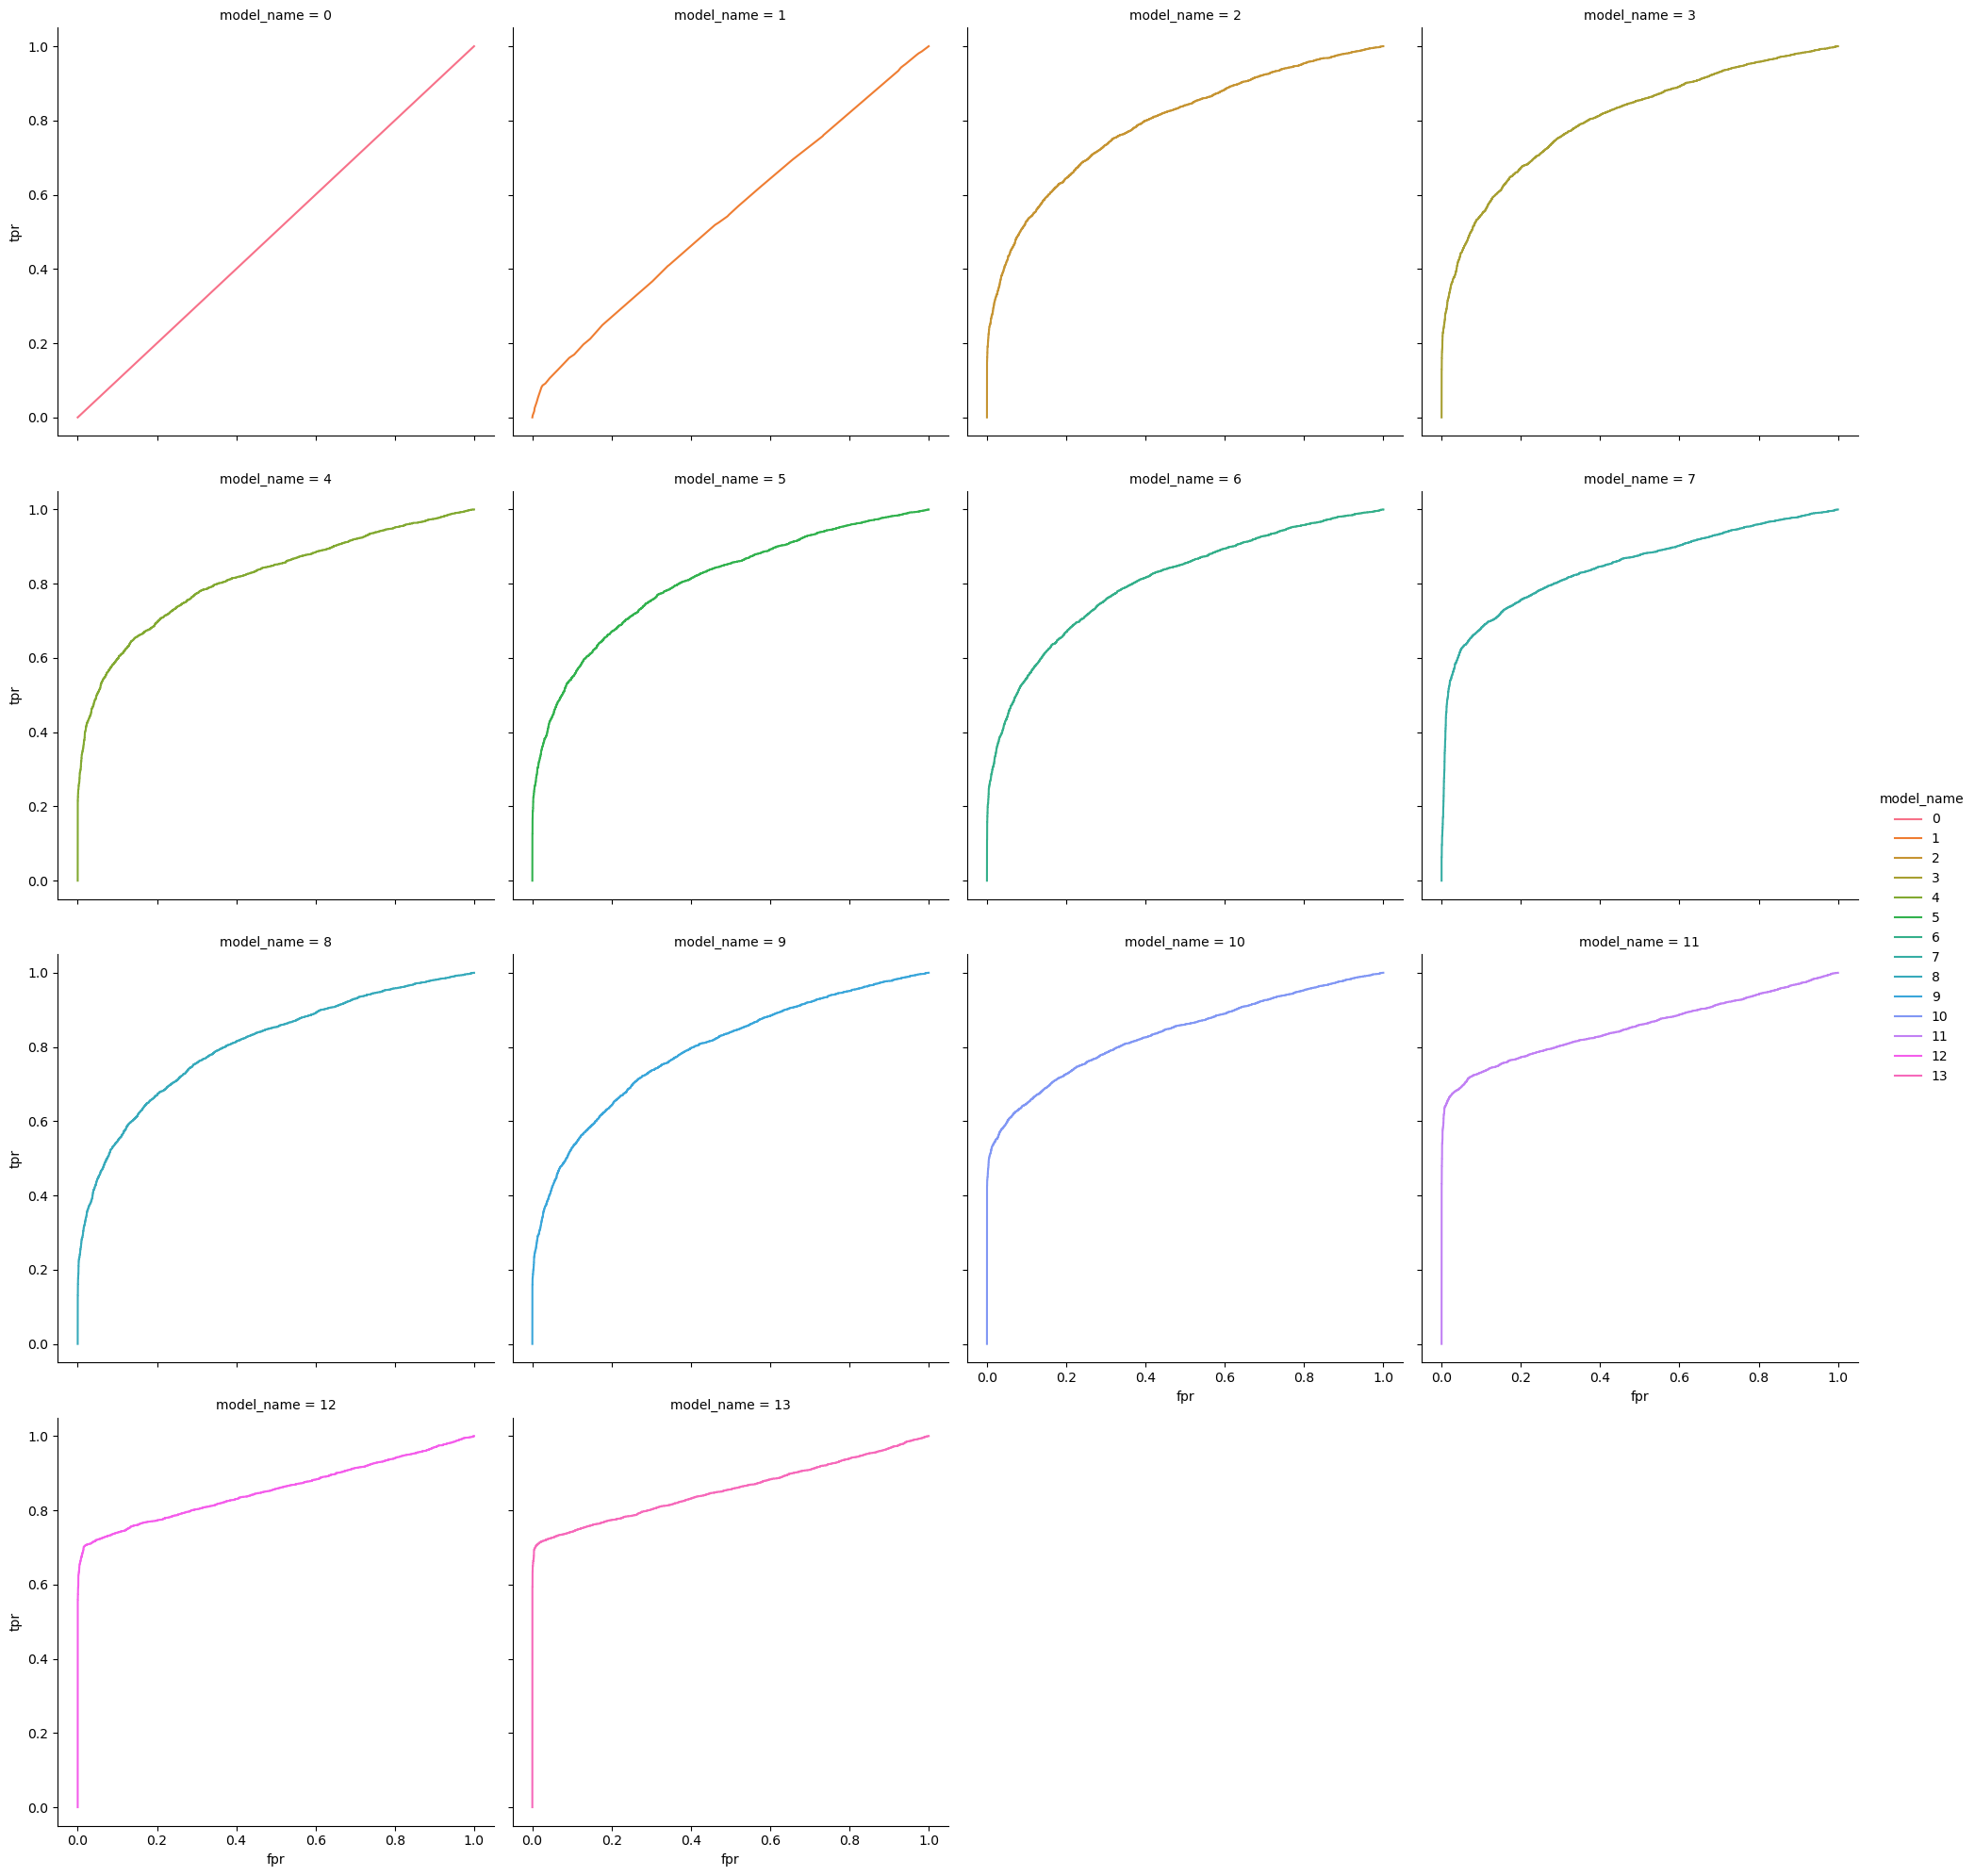

In [258]:
sns.relplot(data=roc_df.assign(model_name=roc_df.model_name.astype(str)), 
            x='fpr', 
            y='tpr', 
            hue='model_name',
            kind='line', 
            estimator=None, 
            units='model_name',
            col='model_name', col_wrap=4)

plt.show()

## Save Best Model - Model 13 w/ Highest Accuracy w/ Least Coefficients

### Save Model

In [231]:
with open('model_13.pkl', 'wb') as f:
    pickle.dump(model_13, f)
print('model saved to model_13.pkl')

model saved to model_13.pkl


### Load Model

In [232]:
try:
    with open('model_13.pkl', 'rb') as f:
        model_13 = pickle.load(f)
except FileNotFoundError:
    print('model_13.pkl not found')
except pickle.UnpicklingError:
    print('failed to unpickle model_13.pkl (file may be corrupted or unsafe)')
else:
    print('model loaded from model_13.pkl')

model loaded from model_13.pkl


### Inference on New Data

In [246]:
new_ci_data = pd.DataFrame({
    'login_attempts': [4],
    'failed_logins': [6],
    'ip_reputation_score': [0.5]
})

predicted_attack_detected = model_13.predict(new_ci_data)
print(f'predicted attack detected for the new ci data: {predicted_attack_detected[0]}')

predicted attack detected for the new ci data: 1.0
